/home/zaman-m65/miniconda3/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0
Train: 30372, Val: 6508, Test: 6509


/home/zaman-m65/miniconda3/envs/my_env/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



Epoch 1/50
  Train Acc: 0.5090
  Val F1: 0.5603, Recall: 0.5762

Epoch 2/50
  Train Acc: 0.5823
  Val F1: 0.6076, Recall: 0.6146

Epoch 3/50
  Train Acc: 0.5974
  Val F1: 0.6146, Recall: 0.6258

Epoch 4/50
  Train Acc: 0.6362
  Val F1: 0.6518, Recall: 0.6567

Epoch 5/50
  Train Acc: 0.6723
  Val F1: 0.6714, Recall: 0.6780

Epoch 6/50
  Train Acc: 0.7051
  Val F1: 0.6969, Recall: 0.7007

Epoch 7/50
  Train Acc: 0.7285
  Val F1: 0.7232, Recall: 0.7267

Epoch 8/50
  Train Acc: 0.7509
  Val F1: 0.7417, Recall: 0.7420

Epoch 9/50
  Train Acc: 0.7699
  Val F1: 0.7498, Recall: 0.7533

Epoch 10/50
  Train Acc: 0.7925
  Val F1: 0.7665, Recall: 0.7690

Epoch 11/50
  Train Acc: 0.8069
  Val F1: 0.7741, Recall: 0.7785

Epoch 12/50
  Train Acc: 0.8286
  Val F1: 0.8030, Recall: 0.8028

Epoch 13/50
  Train Acc: 0.8461
  Val F1: 0.8243, Recall: 0.8256

Epoch 14/50
  Train Acc: 0.8619
  Val F1: 0.8402, Recall: 0.8412

Epoch 15/50
  Train Acc: 0.8760
  Val F1: 0.8153, Recall: 0.8193

Epoch 16/50
  Trai

/tmp/ipykernel_2324589/3660919326.py:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet.pth", map_location=DEVICE))
/home/zaman


Test Acc: 0.9800, F1: 0.9799, Recall: 0.9799


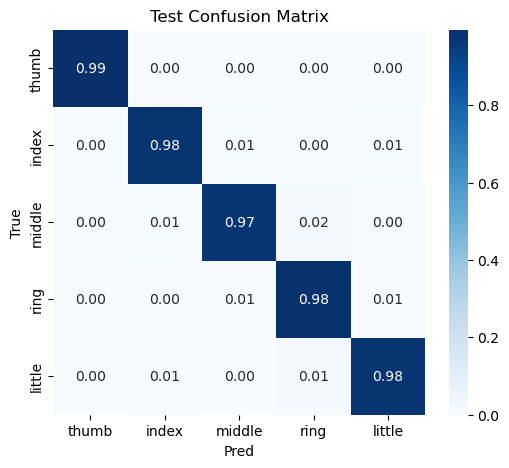

In [1]:
import os
import re
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import (
    Dataset, DataLoader, WeightedRandomSampler, random_split
)
import torchvision.transforms as T
import timm
import kornia
from sklearn.metrics import (
    f1_score, recall_score, accuracy_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Configuration
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

DATA_DIRS = [
    os.path.expanduser("~/data/SOCOFing/Real"),
    os.path.expanduser("~/data/SOCOFing/Altered/Altered-Easy"),
    os.path.expanduser("~/data/SOCOFing/Altered/Altered-Medium"),
    os.path.expanduser("~/data/SOCOFing/Altered/Altered-Hard"),
]
BATCH_SIZE     = 32
NUM_WORKERS    = 4
IMG_SIZE       = 224
NUM_CLASSES    = 5   # thumb, index, middle, ring, little
EPOCHS         = 50
LR_HEAD        = 1e-3
LR_BACKBONE    = 1e-5
FREEZE_EPOCHS  = 3
PATIENCE       = 3

FINGER_ORDER = ["thumb", "index", "middle", "ring", "little"]
FINGER_MAP   = {i: name for i, name in enumerate(FINGER_ORDER)}

# 2) Dataset & Transforms
class FingerprintDataset(Dataset):
    def __init__(self, roots, transform=None):
        if isinstance(roots, str):
            roots = [roots]
        self.paths, self.labels = [], []
        exts = {".bmp",".png",".jpg",".jpeg",".tif",".tiff"}
        pat = re.compile(r"(thumb|index|middle|ring|little)", re.IGNORECASE)
        for root in roots:
            if not os.path.isdir(root): continue
            for fn in sorted(os.listdir(root)):
                ext = os.path.splitext(fn)[1].lower()
                if ext in exts:
                    m = pat.search(fn)
                    if m:
                        idx = FINGER_ORDER.index(m.group(1).lower())
                        self.paths.append(os.path.join(root, fn))
                        self.labels.append(idx)
        if not self.paths:
            raise RuntimeError(f"No images found in {roots}")
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        arr = np.array(img)
        if self.transform:
            arr = self.transform(arr)
        return arr, self.labels[i]

train_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandAugment(num_ops=2, magnitude=9),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])
val_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# 3) DataLoaders with 70/15/15 split
def make_loaders():
    ds = FingerprintDataset(DATA_DIRS, transform=None)
    n = len(ds)
    n_train = int(0.70 * n)
    n_val   = int(0.15 * n)
    n_test  = n - n_train - n_val
    train_ds, val_ds, test_ds = random_split(ds, [n_train, n_val, n_test])

    train_ds.dataset.transform = train_transform
    val_ds.dataset.transform   = val_transform
    test_ds.dataset.transform  = val_transform

    # weighted sampler on train
    lbls = [ds.labels[i] for i in train_ds.indices]
    counts = np.bincount(lbls, minlength=NUM_CLASSES)
    weights = 1.0 / counts
    samp_w = [weights[l] for l in lbls]
    sampler = WeightedRandomSampler(samp_w, num_samples=len(samp_w), replacement=True)

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, sampler=sampler,
        num_workers=NUM_WORKERS, pin_memory=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )
    test_loader = DataLoader(
        test_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True
    )
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = make_loaders()
print(f"Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")

# 4) ResNet50 Model
class ResNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "resnet50", pretrained=True, num_classes=0, global_pool="avg"
        )
        feat_dim = self.backbone.num_features + 2
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        f = self.backbone(x)
        gray = kornia.color.rgb_to_grayscale(x)
        blur = kornia.filters.gaussian_blur2d(gray,(5,5),(1.0,1.0))
        edges= kornia.filters.sobel(blur)
        emap = torch.sqrt((edges**2).sum(1,keepdim=True))
        mv   = emap.view(emap.size(0), -1)
        stats= torch.cat([mv.mean(1,keepdim=True), mv.std(1,keepdim=True)],1)
        return self.head(torch.cat([f, stats],1))

model = ResNetModel().to(DEVICE)
for p in model.backbone.parameters():
    p.requires_grad = False

# 5) Training setup
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
opt_head = optim.AdamW(model.head.parameters(), lr=LR_HEAD)
opt_all  = None
scaler   = torch.amp.GradScaler()
scheduler= optim.lr_scheduler.ReduceLROnPlateau(opt_head, "max", patience=PATIENCE)

best_f1, no_imp = 0.0, 0

# 6) Training loop
for ep in range(1, EPOCHS+1):
    print(f"\nEpoch {ep}/{EPOCHS}")
    if ep == FREEZE_EPOCHS+1:
        for p in model.backbone.parameters(): p.requires_grad=True
        opt_all = optim.AdamW(model.parameters(), lr=LR_BACKBONE)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_all, "max", patience=PATIENCE)

    model.train()
    tot=corr=0
    opt = opt_head if ep <= FREEZE_EPOCHS else opt_all
    for imgs, labs in train_loader:
        imgs,labs = imgs.to(DEVICE), labs.to(DEVICE)
        opt.zero_grad()
        with torch.amp.autocast(device_type="cuda"):
            outs = model(imgs)
            loss = criterion(outs, labs)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        preds = outs.argmax(1)
        corr += (preds==labs).sum().item(); tot += labs.size(0)
    print(f"  Train Acc: {corr/tot:.4f}")

    # val
    model.eval()
    y_t,y_p = [],[]
    with torch.no_grad():
        for imgs,labs in val_loader:
            imgs = imgs.to(DEVICE)
            outs = model(imgs)
            preds = outs.argmax(1).cpu().numpy()
            y_p.extend(preds); y_t.extend(labs.numpy())
    f1 = f1_score(y_t,y_p,average="macro")
    rec= recall_score(y_t,y_p,average="macro")
    print(f"  Val F1: {f1:.4f}, Recall: {rec:.4f}")
    scheduler.step(f1)

    if f1>best_f1:
        best_f1, no_imp = f1, 0
        torch.save(model.state_dict(),"best_resnet.pth")
    else:
        no_imp+=1
        if no_imp>PATIENCE:
            print("Early stopping."); break

# 7) Test evaluation
model.load_state_dict(torch.load("best_resnet.pth", map_location=DEVICE))
model.eval()
y_t,y_p = [],[]
with torch.no_grad():
    for imgs,labs in test_loader:
        imgs = imgs.to(DEVICE)
        outs = model(imgs)
        preds = outs.argmax(1).cpu().numpy()
        y_p.extend(preds); y_t.extend(labs.numpy())

acc = accuracy_score(y_t,y_p)
f1  = f1_score(y_t,y_p,average="macro")
rec = recall_score(y_t,y_p,average="macro")
print(f"\nTest Acc: {acc:.4f}, F1: {f1:.4f}, Recall: {rec:.4f}")

# 8) Confusion matrix on test
cm = confusion_matrix(y_t,y_p)
cmn= cm.astype(float)/cm.sum(axis=1)[:,None]
plt.figure(figsize=(6,5))
sns.heatmap(cmn,annot=True,fmt=".2f",
            xticklabels=FINGER_ORDER, yticklabels=FINGER_ORDER,
            cmap="Blues")
plt.xlabel("Pred"); plt.ylabel("True"); plt.title("Test Confusion Matrix")
plt.show()


In [2]:
# 4) Finally call it:
test_path = "/home/zaman-m65/data/SOCOFing/Real/9__M_Right_index_finger_CR.BMP"
predicted_label, confidence = visualize_prediction(test_path, model)
print(f"Predicted: {predicted_label}, Confidence: {confidence*100:.1f}%")

NameError: name 'visualize_prediction' is not defined